# Signal Contributions

This notebook helps to calculate signal contributions of various areas in the footprint of a CRNS detector, and to determine the practical footprint distance interactively. Examples are provided to read png image data as a field soil moisture pattern and to overlay URANOS simulation results.

1. <a href="#fieldatdistance">Field at a Distance</a>
2. <a href="#footprint">The Practical Footprint</a>
3. <a href="#contributions">Signal contributions in a user-define pattern</a>
4. <a href="#comparisonuranos">Comparison to URANOS</a>

In [1]:
import os
from glob import glob
from scipy import optimize
# Methods and tools from Corny and other publications
from corny.figure import Figure
from corny.uranos import URANOS
from corny.Schroen2017hess import get_footprint
from corny.Schroen2022hess import Field_at_Distance, Generate_Splitfields, Plot_Field, Plot_Ntheta, Plot_Sensibility, optimize_R
# Interactive Notebook features
from ipywidgets import interactive, Layout, HBox, VBox, fixed

# Domain and Detector properties

Set the main properties of the following scenarios:
- soil bulk density $\varrho_\mathrm{bulk}$ (kg/m³),
- air humidity $h$ (g/m³),
- neutron calibration parameter $N_0$ (cph).

In [2]:
def set_properties(bulk_density=1.43, air_humidity=5, N0=1500):
    return(bulk_density, air_humidity, N0)
properties = interactive(set_properties, bulk_density=(0.5,2.5,0.01), air_humidity=(0.1,25,0.1), N0=(100,10000,10))
properties

interactive(children=(FloatSlider(value=1.43, description='bulk_density', max=2.5, min=0.5, step=0.01), FloatS…

In [3]:
bulk_density, air_humidity, N0 = properties.result

<a id="fieldatdistance"></a>

# 1. Field at a Distance

Consider a main field with $\theta_1$ and a remote field with $\theta_2$ at the distance $R$. 
- What is the remote field's relative contribution to the detector signal?
- What is the effective neutron counts and effective soil moisture measured by the detector?
- Is the change in detected neutrons significant with regards to sensor precision? (compared to the uniform case $\theta_2=\theta_1$))

In [4]:
# Plotting function
def show_field_at_distance(R=100, theta1=0.1, theta2=0.3):
    size = 499
    # Make field matrix
    M = Generate_Splitfields(size, R)
    # Calculate neutron response
    N1, N2, Neff, thetaeff, c1, c2 = Field_at_Distance(R, theta1=theta1, theta2=theta2,
                                                       hum=air_humidity, N0=N0, bd=bulk_density,
                                                       verbose=False, max_radius=500)
    # Plot
    with Figure(size=(16,5), layout=(1,3), gridspec_kw={'width_ratios': [2, 2, 1]}) as axes:
        Plot_Field(ax=axes[0], Var=M, R=R, extent=size, x_marker=True, annotate=(c1, c2))
        Plot_Ntheta(axes[1], R, theta1, theta2, thetaeff, N1, N2, Neff, hum=air_humidity, off=0, bd=bulk_density, N0=N0)
        Plot_Sensibility(axes[2], N1, Neff)

# Interactive 
plots = interactive(show_field_at_distance, R=(0, 400, 1), theta1=(0.01, 0.8, 0.01), theta2 =(0.01, 0.8, 0.01))
controls = HBox(plots.children[:-1], layout = Layout(flex_flow='row wrap'))
output = plots.children[-1]
output.layout.height = '350px'
display(VBox([controls, output]))

<a id="footprint"></a>

# 2. The Practical Footprint

Consider a main field with $\theta_1$ and a remote field that changes from $\theta_1$ to $\theta_2$. 
- What is the remote field's maximal distance $R$, such that the change is still sensible for a given detector sensitivity $\sigma_N$?

In [5]:
def find_and_show_distance(dN=0.01, theta1=0.1, theta2=0.3, N0=1500, bd=1.43):
    size = 499
    
    R = optimize.newton(optimize_R, 1, args=(theta1, theta2, dN, N0, bulk_density, False, 500,))
    
    N1, N2, Neff, thetaeff, c1, c2 = Field_at_Distance(R, theta1=theta1, theta2=theta2, N0=1500, bd=bd, verbose=False, max_radius=500)
    R86 = get_footprint(thetaeff, air_humidity, 1013)
    
    M = Generate_Splitfields(size, int(R))
    
    with Figure(size=(16,5), layout=(1,3), gridspec_kw={'width_ratios': [2, 2, 1]}) as axes:
        
        Plot_Field(ax=axes[0], Var=M, R=R, extent=size, x_marker=True, annotate=(c1, c2))
        Plot_Ntheta(axes[1], R, theta1, theta2, thetaeff, N1, N2, Neff)
        Plot_Sensibility(axes[2], N1, Neff)
        
plots = interactive(find_and_show_distance, dN=(0.001, 0.1, 0.001), theta1=(0.01, 0.8, 0.01), theta2 =(0.01, 0.8, 0.01), N0=fixed(N0), bd=fixed(bulk_density))
controls = HBox(plots.children[:-1], layout = Layout(flex_flow='row wrap'))
output = plots.children[-1]
output.layout.height = '350px'
display(VBox([controls, output]))

<a id="contributions"></a>

# 3. Signal contributions of a user-defined pattern

## 3.1. Edit your own pixel image

1. Open an image software (e.g., Paint)
2. Copy an example image or create a new image of size 499x499 pixels
3. Change the colors based on URANOS material codes: `SM = RGB/2` (e.g., RGB=(10,10,10) for SM=5%)

## 3.2. Select the image file

Use the following form to specify the domain:

1. select the PNG file with the RGB-coded soil moisture pattern
2. scaling: how many meters correspond to one pixel in the image?
3. air humidity of the domain

In [6]:
def select_image_files(files, scaling=2, air_humidity=5):
    return(files, scaling, air_humidity)
select_file = interactive(select_image_files, files=glob('examples/*.png'),
                          scaling=(0.1,10,0.1), air_humidity=(1,20,1))
select_file

interactive(children=(Dropdown(description='files', options=('examples\\scenario_complex-500.png',), value='ex…

## 3.3. Generate an URANOS-like Matrix Object

In [7]:
filename = select_file.result[0]
scaling = select_file.result[1]
air_humidity = select_file.result[2]

X = URANOS(folder='', scaling=scaling, hum=air_humidity)
X = X.read_materials(filename)
X = X.material2sm().generate_distance().genereate_weights().find_regions().estimate_neutrons()

Imported map `.Materials` (499 x 499), center at (249.0, 249.0).
  One pixel in the data equals 2 meters in reality (998 x 998)
  Material codes: 10, 40, 60, 100, 139, 218
  Guessing default material: 40
Generated soil moisture map `.SM`, values: 0.05, 0.2, 0.3, 0.5, 0.695, 1.09
Nearby avg. sm is 0.22 +/- 0.13, updated footprint radius to 166 m.
Generated distance map `.Distance`, reaching up to 704.3 meters.
Generated areal weights `.Weights`, ranging from 0.000000 to 0.185840.
Found 14 regions, mapped to `.Regions`, DataFrame generated as `.region_data`.
Estimated neutrons from soil moisture, `.Neutrons` (574 +/- 73)
Estimated their signal contributions, `.Contributions`


## 3.4. Browse the results

1. The data table `X.region_data` shows properties of all the regions in the domain.  
    Use `X.region_data.to_csv('file.csv')` to export.

In [8]:
X.region_data.drop(X.region_data[X.region_data.Materials==218.0].index, inplace=True)
X.region_data.head(3)

,Materials,center_mass,center_geom,area,SM,Distance_min,Distance_com,Weights,Neutrons,Contributions,Origins,Density,Regions,Neutrons_diff,Contributions_diff
id,,,,,,,,,,,,,,,
0,40.0,"[245, 248]","[249, 249]",0.870077,0.2,0.0,8.246211,0.787411,572.586241,0.786414,NaN,NaN,0,NaN,NaN
1,10.0,"[317, 181]","[312, 187]",0.019598,0.05,176.283862,192.333044,0.011149,841.269463,0.01636,NaN,NaN,1,NaN,NaN
2,139.0,"[347, 152]","[330, 168]",0.008755,0.695,251.602862,275.775271,0.002089,387.607437,0.001412,NaN,NaN,2,NaN,NaN


2. The distribution of area size, soil moisture, and contributions in the different regions.  
    Use argument `Figure(..., save='file.pdf')` to export.

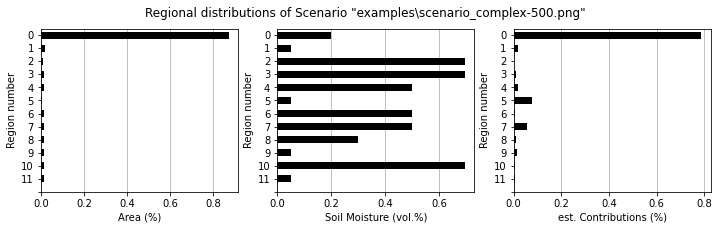

In [9]:
with Figure('Regional distributions of Scenario "%s"' % filename, layout=(1,3), size=(12,3)) as ax:
    X.histogram(ax[0], 'area')
    X.histogram(ax[1], 'SM')
    X.histogram(ax[2], 'Contributions')

3. Average soil moisture seen by the CRNS detector using different calculation approaches:
    - simple average of all soil moisture fields: $\sim\sum\theta_i/n$,
    - average of soil moisture weighted by areal weight: $\sim \sum w_i\theta_i$,
    - weighted average of neutrons: $\hat\theta\sim \theta(\sum w_iN_i)$.

In [10]:
X.average_sm()

Average soil moisture seen by the CRNS detector:
22.1%             field mean (naive approach)
23.3% SM-weighted field mean (lazy approach)
19.9%  N-weighted field mean (correct approach)


4. Display Region numbers $i$, Soil moisture $\theta_i$, and Signal contributions $c_i$ to the detector.  
    Use argument `Figure(..., save='file.pdf')` to export.

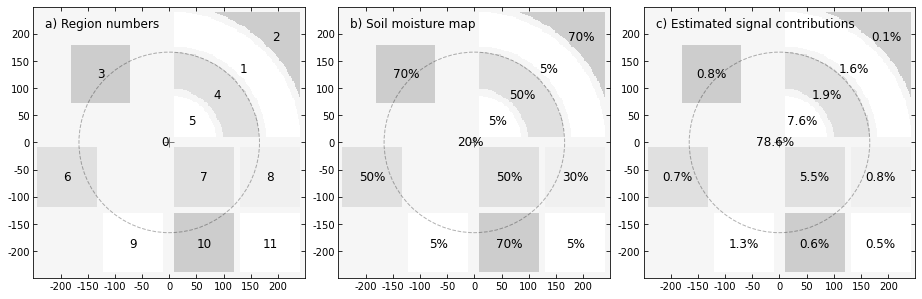

In [11]:
with Figure(layout=(1,3), size=(16,5), gridspec_kw={'wspace':0.08}) as ax: 
    X.plot(ax[0], extent=250, image='SM', annotate='Regions', fontsize=12, title='')
    ax[0].annotate('a) Region numbers', (135, 143), fontsize=12)
    X.plot(ax[1], extent=250, image='SM', annotate='SM', fontsize=12, title='')
    ax[1].annotate('b) Soil moisture map', (135, 143), fontsize=12)
    X.plot(ax[2], extent=250, image='SM', annotate='Contributions', fontsize=12, title='')
    ax[2].annotate('c) Estimated signal contributions', (135, 143), fontsize=12)

## 3.5. What happens if soil moisture changes?

1. Change the soil moisture value (upper panel b) of a certain region (upper panel a).

In [12]:
def modify_sm(Region=0, SM=0.20):
    return(Region, SM)
modified = interactive(modify_sm, Region=list(X.region_data['Regions'].values), SM=(0.01,0.80,0.01))
modified

interactive(children=(Dropdown(description='Region', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11), value=0),…

In [13]:
region, newsm = modified.result
X = X.modify(Region=region, SM=newsm).estimate_neutrons()

Estimated neutrons from soil moisture, `.Neutrons` (574 +/- 73)
Estimated their signal contributions, `.Contributions`


2. Display the changed soil moisture and signal contributions:

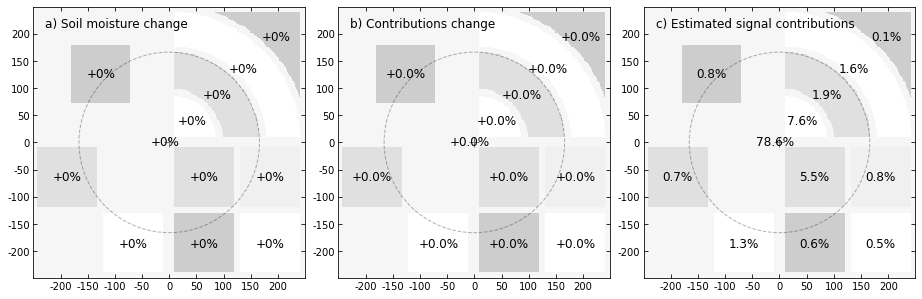

In [14]:
with Figure(layout=(1,3), size=(16,5), gridspec_kw={'wspace':0.08}) as ax: 
    X.plot(ax[0], extent=250, image='SM', annotate='SM_diff', fontsize=12, title='') # need more colors? add: cmap='terrain_r', vmax_factor=1
    ax[0].annotate('a) Soil moisture change', (135, 143), fontsize=12)
    X.plot(ax[1], extent=250, image='SM', annotate='Contributions_diff', fontsize=12, title='')
    ax[1].annotate('b) Contributions change', (135, 143), fontsize=12)
    X.plot(ax[2], extent=250, image='SM', annotate='Contributions', fontsize=12, title='')
    ax[2].annotate('c) Estimated signal contributions', (135, 143), fontsize=12)

3. Average soil moisture seen by the CRNS detector using different calculation approaches (cmp. with 3.4.4)

In [15]:
X.average_sm()

Average soil moisture seen by the CRNS detector:
22.1%             field mean (naive approach)
23.3% SM-weighted field mean (lazy approach)
19.9%  N-weighted field mean (correct approach)


<a id="comparisonuranos"></a>

# 4. Comparison to URANOS simulations

Setup the simulation folder, select the image file, define scaling (1 pixel to meters) and simulated air humidity. 

In [16]:
folder = 'examples/'
def select_uranos_files(image, scaling=2, air_humidity=5):
    return(image, scaling, air_humidity)
select_file = interactive(select_uranos_files, image=glob('examples/*.png'),
                          scaling=(0.1,10,0.1), air_humidity=(1,20,1))
select_file

interactive(children=(Dropdown(description='image', options=('examples\\scenario_complex-500.png',), value='ex…

In [17]:
imgfilename, scaling, air_humidity = select_file.result

X = URANOS(folder=folder, scaling=2, hum=5)
X = X.read_materials(os.path.basename(imgfilename))
X = X.material2sm().generate_distance().genereate_weights().find_regions().estimate_neutrons()
X = X.read_origins('detectorOrigins*')
X = X.read_density('densityMapEpithermal*')

Imported map `.Materials` (499 x 499), center at (249.0, 249.0).
  One pixel in the data equals 2 meters in reality (998 x 998)
  Material codes: 10, 40, 60, 100, 139, 218
  Guessing default material: 40
Generated soil moisture map `.SM`, values: 0.05, 0.2, 0.3, 0.5, 0.695, 1.09
Nearby avg. sm is 0.22 +/- 0.13, updated footprint radius to 166 m.
Generated distance map `.Distance`, reaching up to 704.3 meters.
Generated areal weights `.Weights`, ranging from 0.000000 to 0.185840.
Found 14 regions, mapped to `.Regions`, DataFrame generated as `.region_data`.
Estimated neutrons from soil moisture, `.Neutrons` (574 +/- 73)
Estimated their signal contributions, `.Contributions`
  Reading examples\detectorOrigins20220105-0548_N10000000.csv
  Reading examples\detectorOrigins20220105-0612_N10000000.csv
  Reading examples\detectorOrigins20220105-0831_N10000000.csv
Imported URANOS origins as `.Origins` (499 x 499).
  Reading examples\densityMapEpithermal_20220105-0548_N10000000.csv
  Reading exa

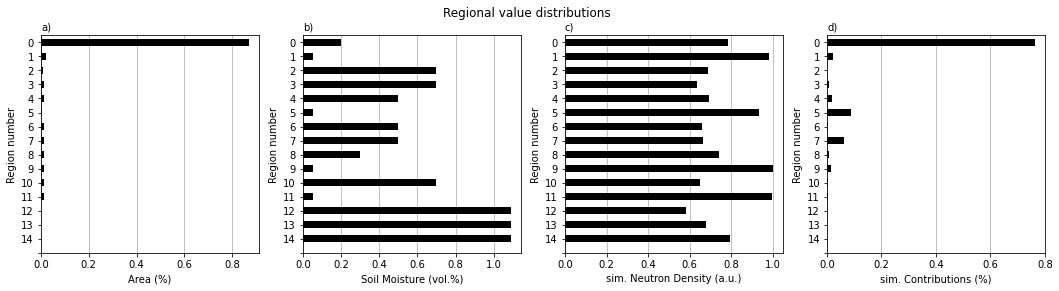

In [18]:
with Figure('Regional value distributions', layout=(1,4), size=(18,4), abc=True) as ax:
    X.histogram(ax[0], 'area')
    X.histogram(ax[1], 'SM')
    X.histogram(ax[2], 'Density')
    X.histogram(ax[3], 'Origins')

Show neutron origin locations and density map. Use `Figure(..., save='file.pdf')` to export.

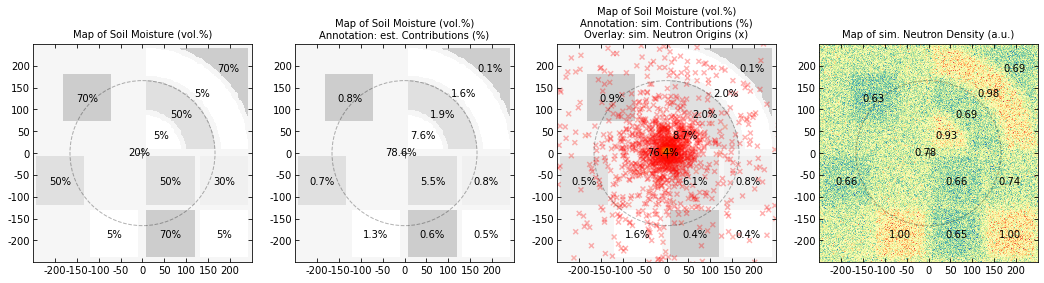

In [19]:
with Figure(layout=(1,4), size=(18,6), save_dpi=120, gridspec_kw={'hspace':0.08}) as ax: 
    X.plot(ax[0], extent=250, image='SM', annotate='SM')
    X.plot(ax[1], extent=250, image='SM', annotate='Contributions')
    X.plot(ax[2], extent=250, image='SM', annotate='Origins', overlay='Origins')
    X.plot(ax[3], extent=250, image='Density', annotate='Density', cmap='Spectral_r', vmax_factor=1)